In [1]:
from functions import data_strat2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



def strat2_box_break(ticker='../database/2330.TW', start='2023-01-01', end='2024-01-01'):
    ticker = ticker.replace(".", "_")
    df = pd.read_parquet(f"{ticker}.parquet")
    df = df[df.index > start]
    return df
df = strat2_box_break()
df['day_count'] = np.arange(0, len(df))

In [24]:
def count_positive_numbers(numbers):
    count = 0
    for num in numbers:
        if num > 0:
            count += 1
    return count
def nav_returns_subplots(ax, df, data_output = True, holding_days=10):
    start = 10000.0
    # strat1:　
    # strat2: signal
    cur = pd.Series([0] * len(df))
    cur[0] = start
    open_position = []
    close_position = []
    returns_pertrade = []
    current = start
    holding = False
    df['pct_change'] = df['Close'].pct_change()
    k = 0
    pct_change_all = 0
    for i in range(len(df)):
        if df['signal'].iloc[i] == False and holding == False:
            cur[i] = current
            continue
        else:
            if holding == False:
                buy_price = df['Close'].iloc[i]
                open_position.append([i, buy_price])
                cur[i] = current
                holding = True
            elif holding == True:
                if df['signal'].iloc[i] == True:
                    k = 0
                pct_change = df['pct_change'].iloc[i]
                pct_change_all += pct_change
                current_open = current * (1+pct_change_all)
                # print(current, pct_change, pct_change_all, current_open, i)
                if k == holding_days:
                    close_price = df['Close'].iloc[i]
                    close_position.append([i, close_price])
                    holding = False
                    current = current_open
                    k = 0
                    pct_change_all = 0
                    returns_pertrade.append(close_price/buy_price - 1)
                cur[i] = current_open
                
                k += 1
    if k != 1:
        close_position.append([i, df['Close'].iloc[i], k-1])

    # data output calculation ===============================

    return_total = cur[len(df)-1]/cur[0] - 1
    avg_return = np.mean(returns_pertrade)
    winrate = count_positive_numbers(returns_pertrade)/len(returns_pertrade)
    if data_output:
        ax.plot(df['day_count'], cur, label='returns')
        for index, i in enumerate(open_position):
            if index == 0:
                ax.axvline(i[0], color='r', label='Open')
            else:
                ax.axvline(i[0], color='r')
        for index, i in enumerate(close_position):
            if index == 0:
                ax.axvline(i[0], color='b', label='Close', alpha=0.3)
            else:
                ax.axvline(i[0], color='b')
        
        print("returns: ", returns_pertrade)
        print("avg per trade: ", avg_return)
        print("winrate: ", winrate)
        print(open_position)
        print(close_position)
        print(f"return: {return_total}")
        print(cur[len(df) - 1])
        return None
    else:
        return return_total, winrate, avg_return


returns:  [0.05471698113207557, -0.012048192771084376, 0.08306709265175716]
avg per trade:  0.041911960337582786
winrate:  0.6666666666666666
[[83, 530.0], [206, 581.0], [252, 626.0]]
[[98, 559.0], [216, 574.0], [266, 678.0]]
return: 0.13053717949376087
11305.37179493761


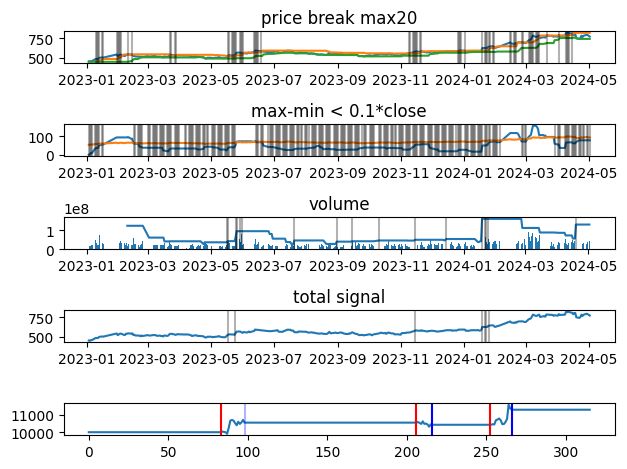

'\n1. 股價超過過去20天的最大值 => 突破箱型區間 \n\n2. 確認過去是不是箱型: 過去20天最大最小收盤價的差必須小於股價的0.12倍 \n\n3. 在價格突破箱型區間的同時交易量也必須破過去一段時間的新高(dafault 20 days)\n'

In [25]:


fig, ax = plt.subplots(5, 1)

# max price - min price ======================================================
df['max_price_past_20d'] = df['Close'].rolling(window=20, min_periods=1).max()
df['min_price_past_20d'] = df['Close'].rolling(window=20, min_periods=1).min()

# price over max20 ============================================================
df['max_price_past_20d_shift5'] = df['max_price_past_20d'].shift(5)
df['price_larger_than_max_20'] = df['max_price_past_20d_shift5'] < df['Close']

ax[0].plot(df['Close'])
ax[0].plot(df['max_price_past_20d_shift5'])
ax[0].plot(df['min_price_past_20d'])
for dates in df[df['price_larger_than_max_20'] == 1].index:
    ax[0].axvline(dates, color="black", alpha=0.3)

# 0.12 of close price, the threshold ==========================================
df['Close_12per'] = df['Close']*0.12
df['max_min_20d_diff'] = df['max_price_past_20d'] - df['min_price_past_20d']
df['max_min_price_less_than_12per'] = df['max_min_20d_diff'] < df['Close_12per']

ax[1].plot(df['max_min_20d_diff'])
ax[1].plot(df['Close_12per'])
for dates in df[df['max_min_price_less_than_12per'] == 1].index:
    ax[1].axvline(dates, color="black", alpha=0.3)

# volume surge ================================================================
df['volume_max20'] = df['Volume'].rolling(window=20).max()
df['volume_max20_shift5'] = df['volume_max20'].shift(5)
df['volume_over_max20_shift5'] = df['volume_max20_shift5'] < df['Volume']

ax[2].bar(df.index, df['Volume'])
ax[2].plot(df['volume_max20'])
for dates in df[df['volume_over_max20_shift5'] == 1].index:
    ax[2].axvline(dates, color="black", alpha=0.3)

# ============================================================================

# df['signal_total'] = (df["price_larger_than_max_20"] == True) & ((df["max_min_price_less_than_12per"] == True) & (df["volume_over_max20_shift5"] == True))
df['price_signal'] = (df["price_larger_than_max_20"] == True) & (df["max_min_price_less_than_12per"] == True)
df['signal'] = (df["volume_over_max20_shift5"] == True) & (df['price_signal'] == True)
ax[3].plot(df['Close'])
for dates in df[df['signal'] == 1].index:
    ax[3].axvline(dates, color="black", alpha=0.3)

ax[0].set_title("price break max20")
ax[1].set_title("max-min < 0.1*close")
ax[2].set_title("volume")
ax[3].set_title("total signal")


nav_returns_subplots(ax[4], df)

plt.tight_layout()
plt.show()

'''
1. 股價超過過去20天的最大值 => 突破箱型區間 \n
2. 確認過去是不是箱型: 過去20天最大最小收盤價的差必須小於股價的0.12倍 \n
3. 在價格突破箱型區間的同時交易量也必須破過去一段時間的新高(dafault 20 days)
'''

In [2]:
from functions import plotting_strat2

returns:  [0.028571446736653572, -0.03455962742016394, 0.10432854256461299, -0.003201658827470366, 0.06488159784510072, -0.10994764397905754]
avg per trade:  0.008345442819945906
winrate:  0.5
[[74, Timestamp('2023-05-05 00:00:00'), 42.0], [103, Timestamp('2023-06-15 00:00:00'), 44.849998474121094], [151, Timestamp('2023-08-25 00:00:00'), 45.04999923706055], [197, Timestamp('2023-11-02 00:00:00'), 46.849998474121094], [213, Timestamp('2023-11-24 00:00:00'), 48.54999923706055], [295, Timestamp('2024-04-01 00:00:00'), 47.75]]
[[85, Timestamp('2023-05-22 00:00:00'), 43.20000076293945], [113, Timestamp('2023-07-03 00:00:00'), 43.29999923706055], [161, Timestamp('2023-09-08 00:00:00'), 49.75], [210, Timestamp('2023-11-21 00:00:00'), 46.70000076293945], [223, Timestamp('2023-12-08 00:00:00'), 51.70000076293945], [308, Timestamp('2024-04-22 00:00:00'), 42.5]]
return: 0.03500552799443768
10350.055279944376


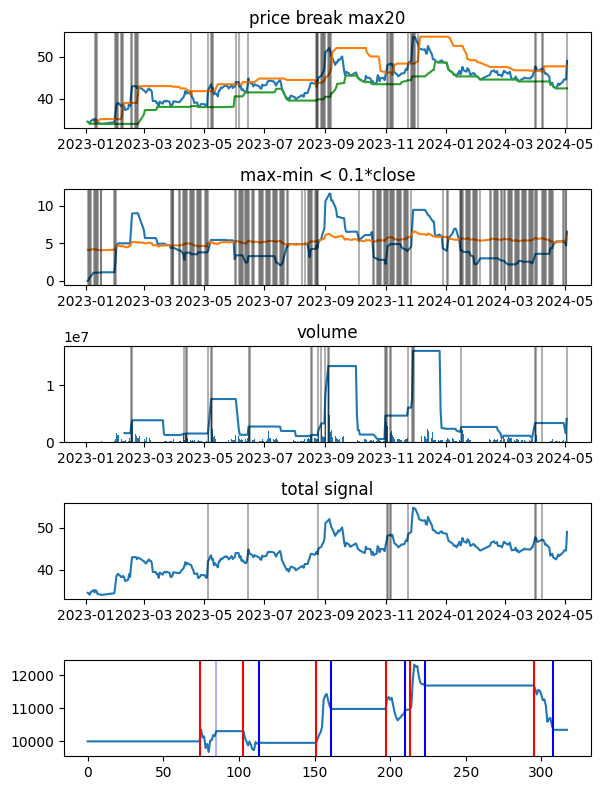

In [3]:
df = plotting_strat2("6173.TWO", start='2023-01-01', holding_days=10)


In [ ]:
9914, 9904, 1432
運動休閒底部:
2762, 8462
